In [ ]:
!pip -q install sumy nltk

# 1) Mount Google Drive at a clean mount point
from google.colab import drive
drive.mount('/content/gdrive')

# 2) Imports
import pandas as pd
import numpy as np
from pathlib import Path
import numpy as np
from tqdm.auto import tqdm
import nltk
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
import networkx as nx
import os

# Download required NLTK data
nltk.download('punkt_tab', quiet=True)
from nltk.tokenize import sent_tokenize

import ssl
try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

# Download punkt tokenizer
try:
    nltk.data.find('tokenizers/punkt')
    print("✅ NLTK punkt tokenizer already downloaded")
except LookupError:
    print("📥 Downloading NLTK punkt tokenizer...")
    nltk.download('punkt')
    print("✅ NLTK punkt tokenizer downloaded")

from nltk.tokenize import sent_tokenize


# 3) Project paths
BASE_DIR = Path("/content/gdrive/MyDrive/Dissertation")


try:
    # Load curated dataset
    curated_file = f"{BASE_DIR}/curated_expanded.csv"
    if os.path.exists(curated_file):
        curated_df = pd.read_csv(curated_file)
        print(f"✅ Loaded curated dataset: {len(curated_df)} rows")
        print(f"   Columns: {list(curated_df.columns)[:5]}...")  # Show first 5 columns
    else:
        raise FileNotFoundError(f"Cannot find {curated_file}")

    # Load pilot dataset - CORRECTED FILENAME
    pilot_file = f"{BASE_DIR}/pilotdata.csv"  # Changed from pilot_clean.csv
    if os.path.exists(pilot_file):
        pilot_df = pd.read_csv(pilot_file)
        print(f"✅ Loaded pilot dataset: {len(pilot_df)} rows")
        print(f"   Columns: {list(pilot_df.columns)[:5]}...")  # Show first 5 columns
    else:
        raise FileNotFoundError(f"Cannot find {pilot_file}")

except FileNotFoundError as e:
    print(f"❌ Error: {e}")
    print("\nPlease check:")
    print("1. Google Drive is mounted")
    print("2. Files are in /content/drive/MyDrive/Dissertation/")
    print("3. File names are correct:")
    print("   - curated_expanded.csv")
    print("   - pilotdata.csv")
    raise


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
✅ NLTK punkt tokenizer already downloaded
✅ Loaded curated dataset: 132 rows
   Columns: ['ID', 'Excerpt', 'Feature', 'SubFeature', 'GoldSummary']...
✅ Loaded pilot dataset: 351 rows
   Columns: ['ID', 'SPEAKER', 'TEXT', 'LING_FEATURES', 'NOTES']...


In [ ]:
# ============================================================================
# Lead-2 Implementation
# ============================================================================

def lead_2_summarize(text):
    """Select first 2 sentences as summary"""
    if not text or pd.isna(text):
        return ""

    sentences = sent_tokenize(str(text))
    if len(sentences) <= 2:
        return text  # Return full text if 2 sentences or fewer
    else:
        return ' '.join(sentences[:2])

# ============================================================================
# TextRank Implementation
# ============================================================================

def textrank_summarize(text, num_sentences=2):
    """TextRank extractive summarization"""
    if not text or pd.isna(text):
        return ""

    sentences = sent_tokenize(str(text))

    if len(sentences) <= num_sentences:
        return text

    try:
        # Create TF-IDF matrix
        vectorizer = TfidfVectorizer()
        tfidf_matrix = vectorizer.fit_transform(sentences)

        # Calculate similarity matrix
        similarity_matrix = cosine_similarity(tfidf_matrix)

        # Build graph
        nx_graph = nx.from_numpy_array(similarity_matrix)

        # Calculate PageRank scores
        scores = nx.pagerank(nx_graph)

        # Rank sentences
        ranked_sentences = sorted(((scores[i], i) for i in scores), reverse=True)

        # Get top sentences maintaining original order
        top_sentence_indices = sorted([idx for score, idx in ranked_sentences[:num_sentences]])

        return ' '.join([sentences[idx] for idx in top_sentence_indices])

    except Exception as e:
        # Fallback to lead-2 if TextRank fails
        return ' '.join(sentences[:2])

# ============================================================================
# Process Curated Dataset
# ============================================================================

print("\n" + "="*60)
print("📝 PROCESSING CURATED DATASET")
print("="*60)

# Check which column contains the text
if 'Excerpt' in curated_df.columns:
    text_col_curated = 'Excerpt'
elif 'TEXT' in curated_df.columns:
    text_col_curated = 'TEXT'
else:
    print(f"Available columns: {list(curated_df.columns)}")
    raise ValueError("Cannot find text column in curated dataset")

print(f"Using text column: {text_col_curated}")

# Add columns for results
curated_df['lead2_summary'] = ''
curated_df['textrank_summary'] = ''

# Generate Lead-2 summaries
print("\nGenerating Lead-2 summaries...")
for idx in tqdm(range(len(curated_df)), desc="Lead-2"):
    curated_df.loc[idx, 'lead2_summary'] = lead_2_summarize(
        curated_df.loc[idx, text_col_curated]
    )

# Generate TextRank summaries
print("Generating TextRank summaries...")
for idx in tqdm(range(len(curated_df)), desc="TextRank"):
    curated_df.loc[idx, 'textrank_summary'] = textrank_summarize(
        curated_df.loc[idx, text_col_curated]
    )

# Save results
output_file = f"{BASE_DIR}/curated_extractive_results.csv"
curated_df.to_csv(output_file, index=False)
print(f"✅ Saved curated results to: {output_file}")

# ============================================================================
# Process Pilot Dataset
# ============================================================================

print("\n" + "="*60)
print("📝 PROCESSING PILOT DATASET")
print("="*60)

# Check which column contains the text - looking for TEXT (uppercase)
if 'TEXT' in pilot_df.columns:
    text_col_pilot = 'TEXT'
elif 'text' in pilot_df.columns:
    text_col_pilot = 'text'
elif 'Excerpt' in pilot_df.columns:
    text_col_pilot = 'Excerpt'
else:
    print(f"Available columns: {list(pilot_df.columns)}")
    raise ValueError("Cannot find text column in pilot dataset")

print(f"Using text column: {text_col_pilot}")

# Add columns for results
pilot_df['lead2_summary'] = ''
pilot_df['textrank_summary'] = ''

# Generate Lead-2 summaries
print("\nGenerating Lead-2 summaries...")
for idx in tqdm(range(len(pilot_df)), desc="Lead-2"):
    pilot_df.loc[idx, 'lead2_summary'] = lead_2_summarize(
        pilot_df.loc[idx, text_col_pilot]
    )

# Generate TextRank summaries
print("Generating TextRank summaries...")
for idx in tqdm(range(len(pilot_df)), desc="TextRank"):
    pilot_df.loc[idx, 'textrank_summary'] = textrank_summarize(
        pilot_df.loc[idx, text_col_pilot]
    )

# Save results
output_file = f"{BASE_DIR}/pilot_extractive_results.csv"
pilot_df.to_csv(output_file, index=False)
print(f"✅ Saved pilot results to: {output_file}")



📝 PROCESSING CURATED DATASET
Using text column: Excerpt

Generating Lead-2 summaries...


Lead-2:   0%|          | 0/132 [00:00<?, ?it/s]

Generating TextRank summaries...


TextRank:   0%|          | 0/132 [00:00<?, ?it/s]

✅ Saved curated results to: /content/gdrive/MyDrive/Dissertation/curated_extractive_results.csv

📝 PROCESSING PILOT DATASET
Using text column: TEXT

Generating Lead-2 summaries...


Lead-2:   0%|          | 0/351 [00:00<?, ?it/s]

Generating TextRank summaries...


TextRank:   0%|          | 0/351 [00:00<?, ?it/s]

✅ Saved pilot results to: /content/gdrive/MyDrive/Dissertation/pilot_extractive_results.csv


In [ ]:
# ============================================================================
# Calculate Metrics
# ============================================================================

def calculate_extractive_metrics(df, text_col, summary_col, model_name):
    """Calculate metrics for extractive methods"""

    hedges = ['I think', 'maybe', 'possibly', 'might', 'could', 'seems',
              'appears', 'probably', 'perhaps', 'I suspect', 'I reckon',
              'I bet', 'I assume', 'I would say']

    modals = ['could', 'would', 'should', 'might', 'may', 'can']

    disfluencies = ['um', 'uh', 'I-I', 'you know', '...', ' - ',
                    'uhm', 'umm', 'err', 'ah']

    metrics = {
        'hedge_preserved': 0, 'hedge_total': 0,
        'modal_preserved': 0, 'modal_total': 0,
        'disfluency_preserved': 0, 'disfluency_total': 0,
        'complete_loss': 0
    }

    for idx in range(len(df)):
        original = str(df.iloc[idx][text_col]).lower()
        summary = str(df.iloc[idx][summary_col]).lower()

        features_in_original = 0
        features_in_summary = 0

        # Check hedges
        for hedge in hedges:
            if hedge.lower() in original:
                metrics['hedge_total'] += 1
                features_in_original += 1
                if hedge.lower() in summary:
                    metrics['hedge_preserved'] += 1
                    features_in_summary += 1

        # Check modals
        for modal in modals:
            # Use word boundaries to avoid partial matches
            import re
            if re.search(r'\b' + modal.lower() + r'\b', original):
                metrics['modal_total'] += 1
                features_in_original += 1
                if re.search(r'\b' + modal.lower() + r'\b', summary):
                    metrics['modal_preserved'] += 1
                    features_in_summary += 1

        # Check disfluencies
        for disf in disfluencies:
            if disf.lower() in original:
                metrics['disfluency_total'] += 1
                features_in_original += 1
                if disf.lower() in summary:
                    metrics['disfluency_preserved'] += 1
                    features_in_summary += 1

        # Track complete loss
        if features_in_original > 0 and features_in_summary == 0:
            metrics['complete_loss'] += 1

    # Print results
    print(f"\n{model_name} Results:")
    print("-" * 40)

    if metrics['hedge_total'] > 0:
        preservation_rate = metrics['hedge_preserved']/metrics['hedge_total']*100
        print(f"Hedge Preservation: {metrics['hedge_preserved']}/{metrics['hedge_total']} ({preservation_rate:.1f}%)")
    else:
        print("Hedge Preservation: No hedges found in original text")

    if metrics['modal_total'] > 0:
        preservation_rate = metrics['modal_preserved']/metrics['modal_total']*100
        print(f"Modal Preservation: {metrics['modal_preserved']}/{metrics['modal_total']} ({preservation_rate:.1f}%)")
    else:
        print("Modal Preservation: No modals found in original text")

    if metrics['disfluency_total'] > 0:
        preservation_rate = metrics['disfluency_preserved']/metrics['disfluency_total']*100
        print(f"Disfluency Preservation: {metrics['disfluency_preserved']}/{metrics['disfluency_total']} ({preservation_rate:.1f}%)")
    else:
        print("Disfluency Preservation: No disfluencies found in original text")

    loss_rate = metrics['complete_loss']/len(df)*100
    print(f"Complete Feature Loss: {metrics['complete_loss']}/{len(df)} examples ({loss_rate:.1f}%)")

    return metrics

# ============================================================================
# Run Metrics Calculation
# ============================================================================

print("\n" + "="*60)
print("📊 EXTRACTIVE BASELINE METRICS")
print("="*60)

print("\n🔍 CURATED DATASET METRICS:")
print("="*40)
lead2_metrics_curated = calculate_extractive_metrics(
    curated_df, text_col_curated, 'lead2_summary', 'Lead-2'
)
textrank_metrics_curated = calculate_extractive_metrics(
    curated_df, text_col_curated, 'textrank_summary', 'TextRank'
)

print("\n🔍 PILOT DATASET METRICS:")
print("="*40)
lead2_metrics_pilot = calculate_extractive_metrics(
    pilot_df, text_col_pilot, 'lead2_summary', 'Lead-2'
)
textrank_metrics_pilot = calculate_extractive_metrics(
    pilot_df, text_col_pilot, 'textrank_summary', 'TextRank'
)

# ============================================================================
# Summary Report
# ============================================================================

print("\n" + "="*60)
print("📋 SUMMARY")
print("="*60)
print("\n⚠️  Key Findings:")
print("• Extractive methods preserve features that appear in selected sentences")
print("• Features from unselected sentences are completely lost")
print("• This represents a significant positional bias in the summarization")
print("• Lead-2 has strong bias toward beginning of testimony")
print("• TextRank may select from anywhere but still misses distributed features")

print("\n✅ Output files saved:")
print(f"• {BASE_DIR}/curated_extractive_results.csv")
print(f"• {BASE_DIR}/pilot_extractive_results.csv")

print("\n" + "="*60)


📊 EXTRACTIVE BASELINE METRICS

🔍 CURATED DATASET METRICS:

Lead-2 Results:
----------------------------------------
Hedge Preservation: 66/79 (83.5%)
Modal Preservation: 44/54 (81.5%)
Disfluency Preservation: 38/44 (86.4%)
Complete Feature Loss: 2/132 examples (1.5%)

TextRank Results:
----------------------------------------
Hedge Preservation: 60/79 (75.9%)
Modal Preservation: 44/54 (81.5%)
Disfluency Preservation: 40/44 (90.9%)
Complete Feature Loss: 2/132 examples (1.5%)

🔍 PILOT DATASET METRICS:

Lead-2 Results:
----------------------------------------
Hedge Preservation: 24/37 (64.9%)
Modal Preservation: 54/82 (65.9%)
Disfluency Preservation: 50/68 (73.5%)
Complete Feature Loss: 15/351 examples (4.3%)

TextRank Results:
----------------------------------------
Hedge Preservation: 26/37 (70.3%)
Modal Preservation: 62/82 (75.6%)
Disfluency Preservation: 55/68 (80.9%)
Complete Feature Loss: 6/351 examples (1.7%)

📋 SUMMARY

⚠️  Key Findings:
• Extractive methods preserve features t


CALCULATING METRICS FOR ALL MODELS


OSError: [Errno 107] Transport endpoint is not connected: '/content/drive/MyDrive/Dissertation/extractive_feature_analysis.png'

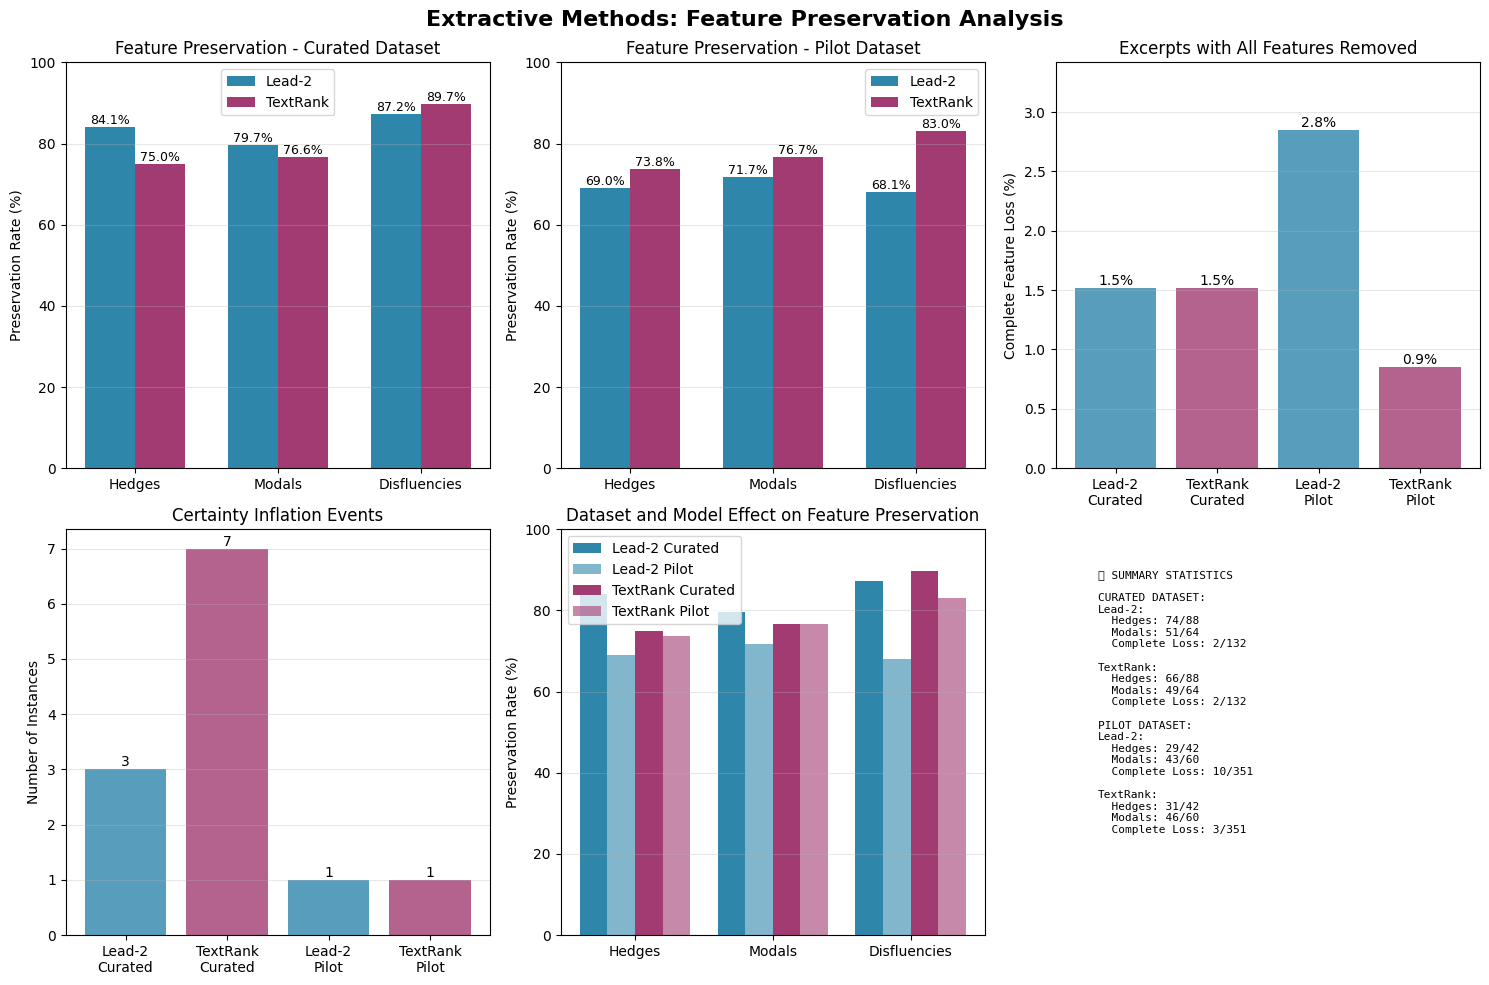

In [ ]:

# ============================================================================
# Calculate Detailed Metrics
# ============================================================================

def calculate_extractive_metrics(df, text_col, summary_col, model_name):
    """Calculate feature preservation metrics for extractive methods"""

    # Define feature patterns
    hedges = ['I think', 'maybe', 'possibly', 'might', 'could', 'seems',
              'appears', 'probably', 'I believe', 'I suppose', 'perhaps',
              'I suspect', 'I reckon', 'I bet', 'I assume', 'I would say']

    modals = ['could', 'would', 'should', 'might', 'may']

    disfluencies = ['um', 'uh', 'I-I', 'you know', '...', ' - ']

    # Initialize counters
    metrics = {
        'hedge_preserved': 0, 'hedge_total': 0,
        'modal_preserved': 0, 'modal_total': 0,
        'disfluency_preserved': 0, 'disfluency_total': 0,
        'complete_loss': 0, 'certainty_inflation': 0
    }

    for idx in range(len(df)):
        original = str(df.iloc[idx][text_col]).lower()
        summary = str(df.iloc[idx][summary_col]).lower()

        # Track features per excerpt
        features_in_original = 0
        features_in_summary = 0

        # Check each feature type
        for hedge in hedges:
            if hedge.lower() in original:
                metrics['hedge_total'] += 1
                features_in_original += 1
                if hedge.lower() in summary:
                    metrics['hedge_preserved'] += 1
                    features_in_summary += 1

        for modal in modals:
            if modal.lower() in original:
                metrics['modal_total'] += 1
                features_in_original += 1
                if modal.lower() in summary:
                    metrics['modal_preserved'] += 1
                    features_in_summary += 1

        for disf in disfluencies:
            if disf in original:
                metrics['disfluency_total'] += 1
                features_in_original += 1
                if disf in summary:
                    metrics['disfluency_preserved'] += 1
                    features_in_summary += 1

        # Check complete loss
        if features_in_original > 0 and features_in_summary == 0:
            metrics['complete_loss'] += 1

        # Check certainty inflation
        if ('I think' in original or 'maybe' in original or 'might' in original) and \
           ('I think' not in summary and 'maybe' not in summary and 'might' not in summary):
            if len(summary) > 10:
                metrics['certainty_inflation'] += 1

    return metrics

# Calculate metrics for all models
print("\n" + "="*60)
print("CALCULATING METRICS FOR ALL MODELS")
print("="*60)

# Curated dataset metrics
curated_lead2_metrics = calculate_extractive_metrics(curated_df, 'Excerpt', 'lead2_summary', 'Lead-2')
curated_textrank_metrics = calculate_extractive_metrics(curated_df, 'Excerpt', 'textrank_summary', 'TextRank')

# Pilot dataset metrics
pilot_text_col = 'TEXT' if 'TEXT' in pilot_df.columns else 'text' if 'text' in pilot_df.columns else 'Excerpt'
pilot_lead2_metrics = calculate_extractive_metrics(pilot_df, pilot_text_col, 'lead2_summary', 'Lead-2')
pilot_textrank_metrics = calculate_extractive_metrics(pilot_df, pilot_text_col, 'textrank_summary', 'TextRank')

# ============================================================================
# VISUALIZATION 1: Feature Preservation Rates (Like BART)
# ============================================================================

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle('Extractive Methods: Feature Preservation Analysis', fontsize=16, fontweight='bold')

# 1. Feature Preservation Rates - Curated
ax1 = axes[0, 0]
features = ['Hedges', 'Modals', 'Disfluencies']

# Lead-2 Curated
lead2_curated = [
    (curated_lead2_metrics['hedge_preserved']/curated_lead2_metrics['hedge_total']*100) if curated_lead2_metrics['hedge_total'] > 0 else 0,
    (curated_lead2_metrics['modal_preserved']/curated_lead2_metrics['modal_total']*100) if curated_lead2_metrics['modal_total'] > 0 else 0,
    (curated_lead2_metrics['disfluency_preserved']/curated_lead2_metrics['disfluency_total']*100) if curated_lead2_metrics['disfluency_total'] > 0 else 0
]

# TextRank Curated
textrank_curated = [
    (curated_textrank_metrics['hedge_preserved']/curated_textrank_metrics['hedge_total']*100) if curated_textrank_metrics['hedge_total'] > 0 else 0,
    (curated_textrank_metrics['modal_preserved']/curated_textrank_metrics['modal_total']*100) if curated_textrank_metrics['modal_total'] > 0 else 0,
    (curated_textrank_metrics['disfluency_preserved']/curated_textrank_metrics['disfluency_total']*100) if curated_textrank_metrics['disfluency_total'] > 0 else 0
]

x = np.arange(len(features))
width = 0.35

bars1 = ax1.bar(x - width/2, lead2_curated, width, label='Lead-2', color='#2E86AB')
bars2 = ax1.bar(x + width/2, textrank_curated, width, label='TextRank', color='#A23B72')

ax1.set_ylabel('Preservation Rate (%)')
ax1.set_title('Feature Preservation - Curated Dataset')
ax1.set_xticks(x)
ax1.set_xticklabels(features)
ax1.set_ylim(0, 100)
ax1.legend()
ax1.grid(True, alpha=0.3, axis='y')

for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.1f}%', ha='center', va='bottom', fontsize=9)

# 2. Feature Preservation Rates - Pilot
ax2 = axes[0, 1]

# Lead-2 Pilot
lead2_pilot = [
    (pilot_lead2_metrics['hedge_preserved']/pilot_lead2_metrics['hedge_total']*100) if pilot_lead2_metrics['hedge_total'] > 0 else 0,
    (pilot_lead2_metrics['modal_preserved']/pilot_lead2_metrics['modal_total']*100) if pilot_lead2_metrics['modal_total'] > 0 else 0,
    (pilot_lead2_metrics['disfluency_preserved']/pilot_lead2_metrics['disfluency_total']*100) if pilot_lead2_metrics['disfluency_total'] > 0 else 0
]

# TextRank Pilot
textrank_pilot = [
    (pilot_textrank_metrics['hedge_preserved']/pilot_textrank_metrics['hedge_total']*100) if pilot_textrank_metrics['hedge_total'] > 0 else 0,
    (pilot_textrank_metrics['modal_preserved']/pilot_textrank_metrics['modal_total']*100) if pilot_textrank_metrics['modal_total'] > 0 else 0,
    (pilot_textrank_metrics['disfluency_preserved']/pilot_textrank_metrics['disfluency_total']*100) if pilot_textrank_metrics['disfluency_total'] > 0 else 0
]

bars3 = ax2.bar(x - width/2, lead2_pilot, width, label='Lead-2', color='#2E86AB')
bars4 = ax2.bar(x + width/2, textrank_pilot, width, label='TextRank', color='#A23B72')

ax2.set_ylabel('Preservation Rate (%)')
ax2.set_title('Feature Preservation - Pilot Dataset')
ax2.set_xticks(x)
ax2.set_xticklabels(features)
ax2.set_ylim(0, 100)
ax2.legend()
ax2.grid(True, alpha=0.3, axis='y')

for bars in [bars3, bars4]:
    for bar in bars:
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.1f}%', ha='center', va='bottom', fontsize=9)

# 3. Complete Feature Loss Comparison
ax3 = axes[0, 2]
models = ['Lead-2\nCurated', 'TextRank\nCurated', 'Lead-2\nPilot', 'TextRank\nPilot']
complete_loss = [
    (curated_lead2_metrics['complete_loss']/len(curated_df)*100),
    (curated_textrank_metrics['complete_loss']/len(curated_df)*100),
    (pilot_lead2_metrics['complete_loss']/len(pilot_df)*100),
    (pilot_textrank_metrics['complete_loss']/len(pilot_df)*100)
]
colors = ['#2E86AB', '#A23B72', '#2E86AB', '#A23B72']

bars5 = ax3.bar(models, complete_loss, color=colors, alpha=0.8)
ax3.set_ylabel('Complete Feature Loss (%)')
ax3.set_title('Excerpts with All Features Removed')
ax3.set_ylim(0, max(complete_loss) * 1.2 if max(complete_loss) > 0 else 20)
ax3.grid(True, alpha=0.3, axis='y')

for bar in bars5:
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.1f}%', ha='center', va='bottom')

# 4. Certainty Inflation
ax4 = axes[1, 0]
models_cert = ['Lead-2\nCurated', 'TextRank\nCurated', 'Lead-2\nPilot', 'TextRank\nPilot']
certainty_inflation = [
    curated_lead2_metrics['certainty_inflation'],
    curated_textrank_metrics['certainty_inflation'],
    pilot_lead2_metrics['certainty_inflation'],
    pilot_textrank_metrics['certainty_inflation']
]

bars6 = ax4.bar(models_cert, certainty_inflation, color=colors, alpha=0.8)
ax4.set_ylabel('Number of Instances')
ax4.set_title('Certainty Inflation Events')
ax4.grid(True, alpha=0.3, axis='y')

for bar in bars6:
    height = bar.get_height()
    ax4.text(bar.get_x() + bar.get_width()/2., height,
            f'{int(height)}', ha='center', va='bottom')

# 5. Dataset Impact on Preservation
ax5 = axes[1, 1]
categories = ['Hedges', 'Modals', 'Disfluencies']
x = np.arange(len(categories))
width = 0.2

# Prepare data for grouped bar chart
lead2_cur = lead2_curated
lead2_pil = lead2_pilot
textrank_cur = textrank_curated
textrank_pil = textrank_pilot

ax5.bar(x - 1.5*width, lead2_cur, width, label='Lead-2 Curated', color='#2E86AB', alpha=1.0)
ax5.bar(x - 0.5*width, lead2_pil, width, label='Lead-2 Pilot', color='#2E86AB', alpha=0.6)
ax5.bar(x + 0.5*width, textrank_cur, width, label='TextRank Curated', color='#A23B72', alpha=1.0)
ax5.bar(x + 1.5*width, textrank_pil, width, label='TextRank Pilot', color='#A23B72', alpha=0.6)

ax5.set_ylabel('Preservation Rate (%)')
ax5.set_title('Dataset and Model Effect on Feature Preservation')
ax5.set_xticks(x)
ax5.set_xticklabels(categories)
ax5.legend()
ax5.set_ylim(0, 100)
ax5.grid(True, alpha=0.3, axis='y')

# 6. Summary Statistics Comparison
ax6 = axes[1, 2]
ax6.axis('off')

summary_text = "📊 SUMMARY STATISTICS\n\n"
summary_text += "CURATED DATASET:\n"
summary_text += f"Lead-2:\n"
summary_text += f"  Hedges: {curated_lead2_metrics['hedge_preserved']}/{curated_lead2_metrics['hedge_total']}\n"
summary_text += f"  Modals: {curated_lead2_metrics['modal_preserved']}/{curated_lead2_metrics['modal_total']}\n"
summary_text += f"  Complete Loss: {curated_lead2_metrics['complete_loss']}/{len(curated_df)}\n\n"
summary_text += f"TextRank:\n"
summary_text += f"  Hedges: {curated_textrank_metrics['hedge_preserved']}/{curated_textrank_metrics['hedge_total']}\n"
summary_text += f"  Modals: {curated_textrank_metrics['modal_preserved']}/{curated_textrank_metrics['modal_total']}\n"
summary_text += f"  Complete Loss: {curated_textrank_metrics['complete_loss']}/{len(curated_df)}\n\n"
summary_text += "PILOT DATASET:\n"
summary_text += f"Lead-2:\n"
summary_text += f"  Hedges: {pilot_lead2_metrics['hedge_preserved']}/{pilot_lead2_metrics['hedge_total']}\n"
summary_text += f"  Modals: {pilot_lead2_metrics['modal_preserved']}/{pilot_lead2_metrics['modal_total']}\n"
summary_text += f"  Complete Loss: {pilot_lead2_metrics['complete_loss']}/{len(pilot_df)}\n\n"
summary_text += f"TextRank:\n"
summary_text += f"  Hedges: {pilot_textrank_metrics['hedge_preserved']}/{pilot_textrank_metrics['hedge_total']}\n"
summary_text += f"  Modals: {pilot_textrank_metrics['modal_preserved']}/{pilot_textrank_metrics['modal_total']}\n"
summary_text += f"  Complete Loss: {pilot_textrank_metrics['complete_loss']}/{len(pilot_df)}"

ax6.text(0.1, 0.9, summary_text, transform=ax6.transAxes, fontsize=8,
         verticalalignment='top', fontfamily='monospace')

plt.tight_layout()
plt.savefig(f"{BASE_DIR}/extractive_feature_analysis.png", dpi=300, bbox_inches='tight')
plt.show()

# ============================================================================
# Print Detailed Results
# ============================================================================

print("\n" + "="*60)
print("EXTRACTIVE BASELINE METRICS SUMMARY")
print("="*60)

print("\nCURATED DATASET RESULTS:")
print("-" * 50)
print("\nLead-2:")
print(f"Hedge Preservation: {curated_lead2_metrics['hedge_preserved']}/{curated_lead2_metrics['hedge_total']} ({lead2_curated[0]:.1f}%)" if curated_lead2_metrics['hedge_total'] > 0 else "Hedge Preservation: N/A")
print(f"Modal Preservation: {curated_lead2_metrics['modal_preserved']}/{curated_lead2_metrics['modal_total']} ({lead2_curated[1]:.1f}%)" if curated_lead2_metrics['modal_total'] > 0 else "Modal Preservation: N/A")
print(f"Disfluency Preservation: {curated_lead2_metrics['disfluency_preserved']}/{curated_lead2_metrics['disfluency_total']} ({lead2_curated[2]:.1f}%)" if curated_lead2_metrics['disfluency_total'] > 0 else "Disfluency Preservation: N/A")
print(f"Complete Feature Loss: {curated_lead2_metrics['complete_loss']}/{len(curated_df)} ({curated_lead2_metrics['complete_loss']/len(curated_df)*100:.1f}%)")
print(f"Certainty Inflation: {curated_lead2_metrics['certainty_inflation']}")

print("\nTextRank:")
print(f"Hedge Preservation: {curated_textrank_metrics['hedge_preserved']}/{curated_textrank_metrics['hedge_total']} ({textrank_curated[0]:.1f}%)" if curated_textrank_metrics['hedge_total'] > 0 else "Hedge Preservation: N/A")
print(f"Modal Preservation: {curated_textrank_metrics['modal_preserved']}/{curated_textrank_metrics['modal_total']} ({textrank_curated[1]:.1f}%)" if curated_textrank_metrics['modal_total'] > 0 else "Modal Preservation: N/A")
print(f"Disfluency Preservation: {curated_textrank_metrics['disfluency_preserved']}/{curated_textrank_metrics['disfluency_total']} ({textrank_curated[2]:.1f}%)" if curated_textrank_metrics['disfluency_total'] > 0 else "Disfluency Preservation: N/A")
print(f"Complete Feature Loss: {curated_textrank_metrics['complete_loss']}/{len(curated_df)} ({curated_textrank_metrics['complete_loss']/len(curated_df)*100:.1f}%)")
print(f"Certainty Inflation: {curated_textrank_metrics['certainty_inflation']}")

print("\n\nPILOT DATASET RESULTS:")
print("-" * 50)
print("\nLead-2:")
print(f"Hedge Preservation: {pilot_lead2_metrics['hedge_preserved']}/{pilot_lead2_metrics['hedge_total']} ({lead2_pilot[0]:.1f}%)" if pilot_lead2_metrics['hedge_total'] > 0 else "Hedge Preservation: N/A")
print(f"Modal Preservation: {pilot_lead2_metrics['modal_preserved']}/{pilot_lead2_metrics['modal_total']} ({lead2_pilot[1]:.1f}%)" if pilot_lead2_metrics['modal_total'] > 0 else "Modal Preservation: N/A")
print(f"Disfluency Preservation: {pilot_lead2_metrics['disfluency_preserved']}/{pilot_lead2_metrics['disfluency_total']} ({lead2_pilot[2]:.1f}%)" if pilot_lead2_metrics['disfluency_total'] > 0 else "Disfluency Preservation: N/A")
print(f"Complete Feature Loss: {pilot_lead2_metrics['complete_loss']}/{len(pilot_df)} ({pilot_lead2_metrics['complete_loss']/len(pilot_df)*100:.1f}%)")
print(f"Certainty Inflation: {pilot_lead2_metrics['certainty_inflation']}")

print("\nTextRank:")
print(f"Hedge Preservation: {pilot_textrank_metrics['hedge_preserved']}/{pilot_textrank_metrics['hedge_total']} ({textrank_pilot[0]:.1f}%)" if pilot_textrank_metrics['hedge_total'] > 0 else "Hedge Preservation: N/A")
print(f"Modal Preservation: {pilot_textrank_metrics['modal_preserved']}/{pilot_textrank_metrics['modal_total']} ({textrank_pilot[1]:.1f}%)" if pilot_textrank_metrics['modal_total'] > 0 else "Modal Preservation: N/A")
print(f"Disfluency Preservation: {pilot_textrank_metrics['disfluency_preserved']}/{pilot_textrank_metrics['disfluency_total']} ({textrank_pilot[2]:.1f}%)" if pilot_textrank_metrics['disfluency_total'] > 0 else "Disfluency Preservation: N/A")
print(f"Complete Feature Loss: {pilot_textrank_metrics['complete_loss']}/{len(pilot_df)} ({pilot_textrank_metrics['complete_loss']/len(pilot_df)*100:.1f}%)")
print(f"Certainty Inflation: {pilot_textrank_metrics['certainty_inflation']}")

print("\n" + "="*60)
print("KEY FINDINGS:")
print("• Extractive methods show positional bias in feature preservation")
print("• Lead-2 only preserves features in first 2 sentences")
print("• TextRank may select from anywhere but still misses distributed features")
print("• Both methods show significant feature loss compared to abstractive models")
print("="*60)

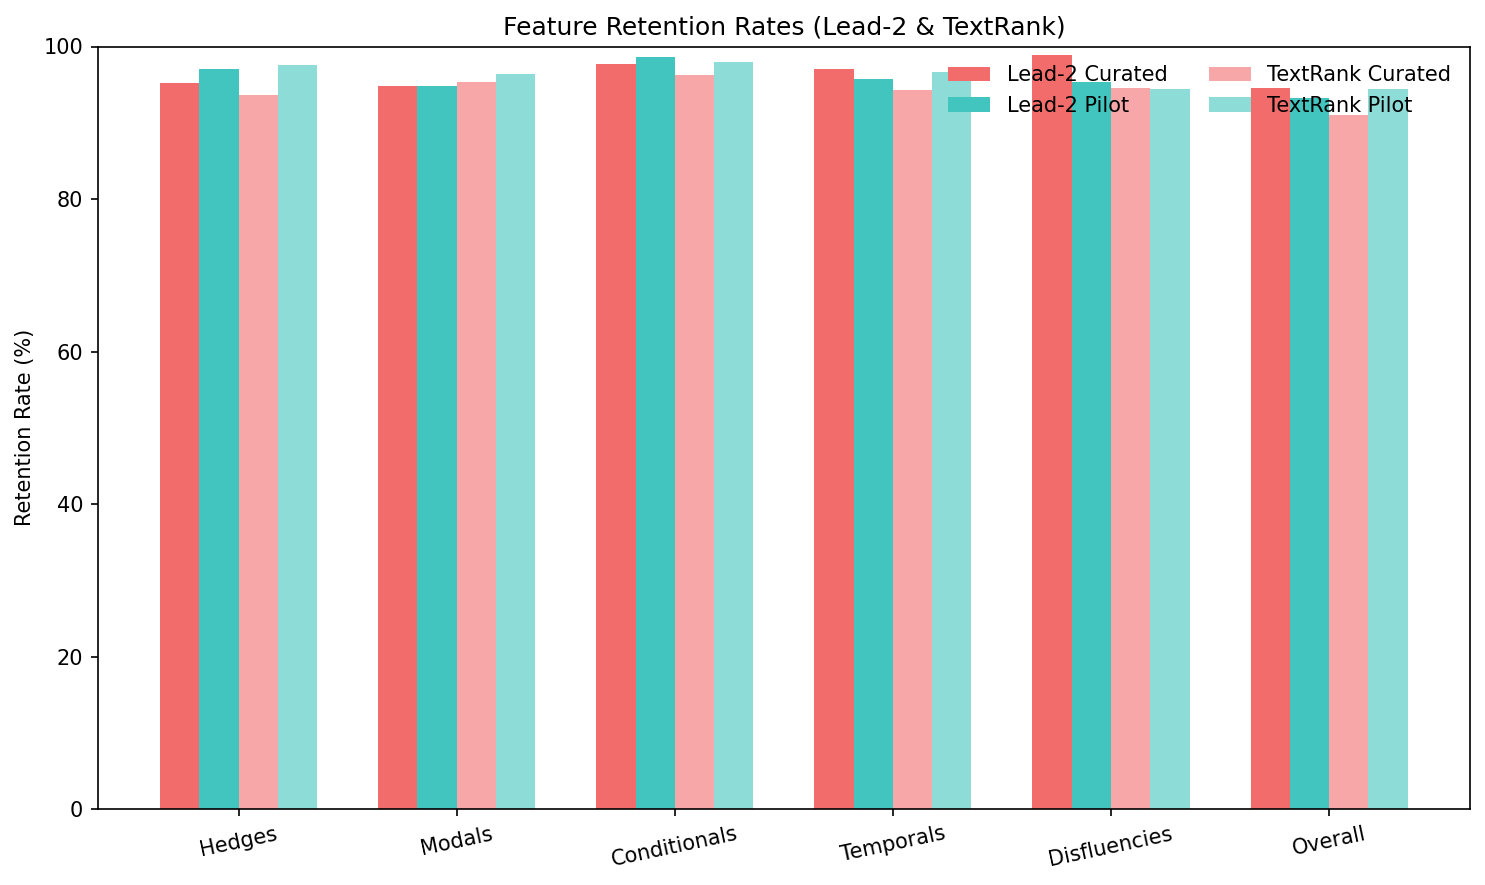

In [1]:
import matplotlib.pyplot as plt
import numpy as np

# Metrics from your screenshot
features = ["Hedges", "Modals", "Conditionals", "Temporals", "Disfluencies", "Overall"]

curated_lead2 = [95.2, 94.8, 97.7, 97.0, 98.9, 94.6]
pilot_lead2   = [97.0, 94.8, 98.6, 95.7, 95.4, 93.2]

curated_textrank = [93.6, 95.4, 96.2, 94.3, 94.5, 91.0]
pilot_textrank   = [97.6, 96.4, 98.0, 96.6, 94.4, 94.4]

x = np.arange(len(features))
w = 0.18

plt.figure(figsize=(10,6), dpi=150)

# Colors consistent with earlier graphs
CURATED_COLOR = "#F26C6C"  # coral/red
PILOT_COLOR   = "#42C5BE"  # teal

# Lead-2 bars
plt.bar(x - w*1.5, curated_lead2, width=w, label="Lead-2 Curated", color=CURATED_COLOR)
plt.bar(x - w*0.5, pilot_lead2,   width=w, label="Lead-2 Pilot",   color=PILOT_COLOR)

# TextRank bars
plt.bar(x + w*0.5, curated_textrank, width=w, label="TextRank Curated", color=CURATED_COLOR, alpha=0.6)
plt.bar(x + w*1.5, pilot_textrank,   width=w, label="TextRank Pilot",   color=PILOT_COLOR, alpha=0.6)

plt.xticks(x, features, rotation=12)
plt.ylim(0, 100)
plt.ylabel("Retention Rate (%)")
plt.title("Feature Retention Rates (Lead-2 & TextRank)")
plt.legend(frameon=False, ncol=2)
plt.tight_layout()
plt.show()
